<a href="https://colab.research.google.com/github/VictorSwankyTiger/DM2024-Lab1-Homework/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part I: Data Pre-processing

In [1]:
import pandas as pd

In [2]:
# Download the Google Analogy dataset
!wget http://download.tensorflow.org/data/questions-words.txt

--2024-10-03 23:00:25--  http://download.tensorflow.org/data/questions-words.txt
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.214.207, 173.194.206.207, 108.177.121.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.214.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘questions-words.txt’

questions-words.txt 100%[===================>] 589.80K  --.-KB/s    in 0.003s  

2024-10-03 23:00:26 (209 MB/s) - ‘questions-words.txt’ saved [603955/603955]



In [3]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [4]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [5]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.
questions = []
categories = []
sub_categories = []
counter = 0 #countin the first five mention (markin semantic)

categoriy = "semantic"
sub_categoriy = ""

for entry in data:
    if entry.startswith(":"):
        counter = counter+1 #counting
        sub_categoriy = "" #initialize
        sub_categoriy = entry #place as entry
    else:
        #when counting ends shift the categoriy
        if counter < 5:
            categoriy = "semantic"
        else:
            categoriy = "syntatic"
        #place the data into frame
        questions.append(entry)
        categories.append(categoriy)
        sub_categories.append(sub_categoriy)


In [6]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [7]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,semantic,: capital-common-countries
2,Athens Greece Beijing China,semantic,: capital-common-countries
3,Athens Greece Berlin Germany,semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,semantic,: capital-common-countries


In [8]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [12]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [9]:
data = pd.read_csv("questions-words.csv")

In [16]:
MODEL_NAME = "glove-twitter-25"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

[==================================================] 100.0% 104.8/104.8MB downloaded
The Gensim model loaded successfully!


In [17]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []



zero_vector = np.zeros(model.vector_size) #計算0向量

for analogy in tqdm(data["Question"]):
      # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      word_a, word_b, word_c, word_d = analogy.split()
      if word_a in model.key_to_index and word_b in model.key_to_index and word_c in model.key_to_index:
        predicted = model[word_b] + model[word_c] - model[word_a]
        predicted_word_d = model.most_similar(positive=[predicted], topn=1, restrict_vocab=None)[0][0]
        preds.append(predicted_word_d)
        golds.append(word_d)
      else:
        # If any word is not in the vocabulary, append a zero vector
        preds.append("OOV")
        golds.append(word_d)



100%|██████████| 19544/19544 [07:37<00:00, 42.76it/s]


In [18]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semantic, Accuracy: 0.0%
Category: syntatic, Accuracy: 10.607280207494856%
Sub-Category: capital-common-countries, Accuracy: 0.0%
Sub-Category: capital-world, Accuracy: 0.0%
Sub-Category: currency, Accuracy: 0.0%
Sub-Category: city-in-state, Accuracy: 0.0%
Sub-Category: family, Accuracy: 10.079051383399209%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 1.1088709677419355%
Sub-Category: gram2-opposite, Accuracy: 4.433497536945813%
Sub-Category: gram3-comparative, Accuracy: 14.264264264264265%
Sub-Category: gram4-superlative, Accuracy: 13.725490196078432%
Sub-Category: gram5-present-participle, Accuracy: 15.246212121212121%
Sub-Category: gram6-nationality-adjective, Accuracy: 0.0%
Sub-Category: gram7-past-tense, Accuracy: 13.525641025641026%
Sub-Category: gram8-plural, Accuracy: 16.14114114114114%
Sub-Category: gram9-plural-verbs, Accuracy: 18.04597701149425%


參考資料: [資料降維 — t-SNE 降維與視覺化
](https://medium.com/data-science-navigator/%E8%B3%87%E6%96%99%E9%99%8D%E7%B6%AD-t-sne-%E9%99%8D%E7%B6%AD%E8%88%87%E8%A6%96%E8%A6%BA%E5%8C%96-36b4dcfc98d5)

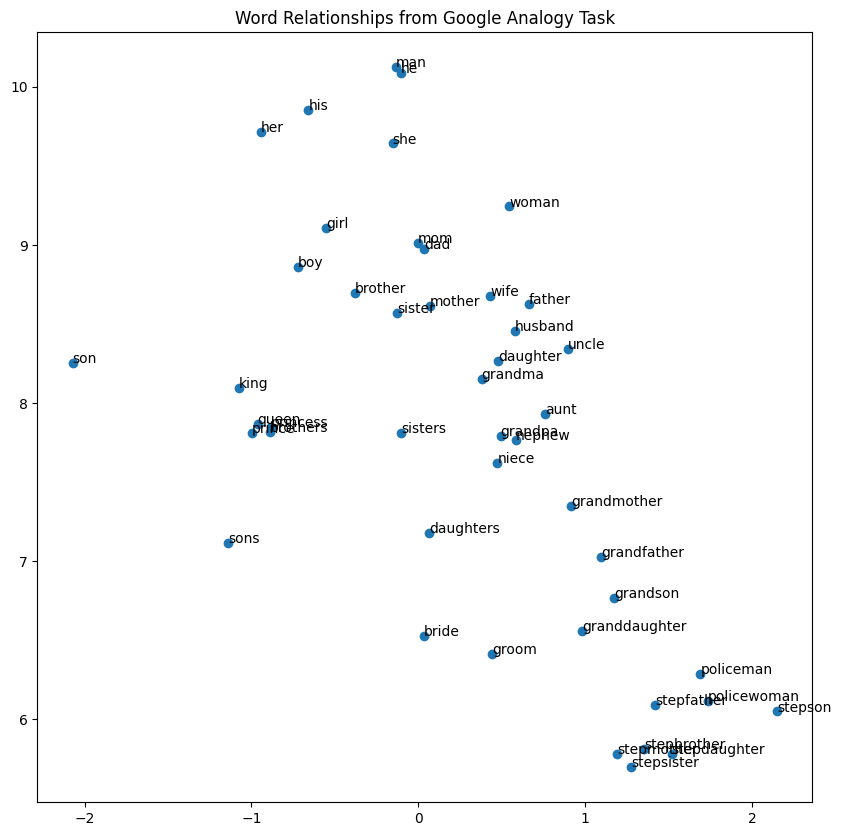

<Figure size 640x480 with 0 Axes>

In [20]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`

family_df = df[df["SubCategory"] == SUB_CATEGORY]
family_questions = family_df["Question"].tolist()

#select unique words
family_words = set()
for analogy in family_questions:
    word_a, word_b, word_c,word_d = analogy.split()[:4]  #分割4個字
    family_words.update([word_a, word_b, word_c, word_d])

#過濾不再model中的字詞
family_words = [word for word in family_words if word in model.key_to_index]

#get embedding
word_vectors = np.array([model[word] for word in family_words])

# 劃出TSNE
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

# 打印TSNE
plt.figure(figsize=(10, 10))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])

# 標記每個點的屬性etc.he,she
for i, word in enumerate(family_words):
    plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]))


plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")


### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd

but Gdown can't. Please check connections and permissions.
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warn

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI

but Gdown can't. Please check connections and permissions.
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warn

In [ ]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz

In [ ]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [ ]:
# Check the first ten lines of the combined file
!head -n 10 wiki_texts_combined.txt

race through the skies the week the world learned to fly is non fiction children book by american writer and historian martin sandler the book focuses on single week in august that introduced aviation to the world the week of an early air show and competition in reims like sandler other books race through the skies includes contemporary photographs newspaper clippings and posters alongside the text as well as detailed information about key characters in the book including the wright brothers glenn curtiss jorge chávez and louis blériot race through the skies was generally well received by critics with some criticisms kirkus reviews described it fascinating eminently entertaining and sometimes frustrating they highlighted how the races are presented in thrilling detail and clearly placed in the context of the history of early aviation publishers weekly indicated that the firsthand accounts will enthrall young aviation enthusiasts school library journal bob hassett similarly wrote this c

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [21]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random

wiki_txt_path = "wiki_texts_combined.txt"
output_path = "wiki_texts_sampled.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.

rate = 0.2 #samplin rate

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here
        lines = f.readlines() #取得f中的資料
        sampled_lines = random.sample(lines, int(len(lines)*rate)) #依照rate隨機選取資料
        output_file.writelines(sampled_lines) #寫入output

FileNotFoundError: [Errno 2] No such file or directory: 'wiki_texts_combined.txt'

In [ ]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.




In [ ]:
data = pd.read_csv("questions-words.csv")

In [ ]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """

In [ ]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`


plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")